# Experimental Validation

KARATE CLUB

In [ ]:
from collections import namedtuple
from networkx import read_edgelist, set_node_attributes
from pandas import read_csv, Series
from numpy import array
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
DataSet = namedtuple(
    'DataSet',
    field_names=['X_train', 'y_train', 'X_test', 'y_test', 'network']
)

def load_karate_club():
    network = read_edgelist(
        'karate.edgelist',
        nodetype=int)

    attributes = read_csv(
        'karate.attributes.csv',
        index_col=['node'])

    for attribute in attributes.columns.values:
        set_node_attributes(
            network,
            values=Series(
                attributes[attribute],
                index=attributes.index).to_dict(),
            name=attribute
        )
  
    X_train,y_train = map(array, zip(*[
        ([node], data['role'] == 'Administrator')
        for node, data in network.nodes(data=True)
        if data['role'] in {'Administrator', 'Instructor'}
    ]))
  
    X_test, y_test = map(array, zip(*[
        ([node], data['community'] == 'Administrator')
        for node, data in network.nodes(data=True)
        if data['role'] == 'Member'
    ]))
 
    return DataSet(
        X_train, y_train,
        X_test, y_test,
        network)

In [ ]:
from networkx import to_numpy_array

In [ ]:
import torch
zkc = load_karate_club()
X_train = zkc.X_train.flatten()
X_test= zkc.X_test.flatten()
y_train = zkc.y_train
y_test = zkc.y_test
print(y_train)
A=to_numpy_array(zkc.network)
#A = to_numpy_matrix(zkc.network)
#A = torch.from_numpy(np.array(A,dtype=object))
print(A)
print(X_train)

[ True False]
[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
[ 0 33]


In [ ]:
!pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 18.7 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [ ]:
mxnet.__version__

NameError: ignored

In [ ]:
from networkx import degree_centrality, betweenness_centrality, shortest_path_length,to_numpy_array
import mxnet.ndarray as nd



Viewing the graph:

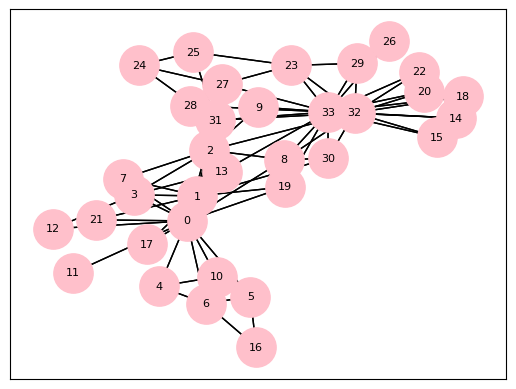

In [ ]:
import networkx as nx
pos = nx.fruchterman_reingold_layout(zkc.network)
nx.draw_networkx(zkc.network, pos=pos, node_size = 800, font_size=8, node_color="pink")
nx.draw_networkx_edges(zkc.network, pos=pos)
edge_labels = nx.get_edge_attributes(zkc.network, 'weight')
nx.draw_networkx_edge_labels(zkc.network, pos=pos, edge_labels=edge_labels)
plt.show()

The GCN model is below:

First, the spectral rule has been implemented. Next, a two-layer architecture is used where the first hidden layer has 4 units and the second hidden layer has 2 units. Finally,  a logistic regression layer is added on top of the GCN for node classification.

In [ ]:
from mxnet.gluon import HybridBlock
from mxnet.gluon.nn import Activation
import mxnet.ndarray as nd

class SpectralRule(HybridBlock):
    def __init__(self, A, in_units, out_units, activation='relu', **kwargs):
        super().__init__(**kwargs)
        I = nd.eye(*A.shape)
        A_hat = A.copy() + I

        D = nd.sum(A_hat, axis=0)
        D_inv = D**-0.5
        D_inv = nd.diag(D_inv)

        A_hat = D_inv * A_hat * D_inv
        
        self.in_units, self.out_units = in_units, out_units
        
        with self.name_scope():
            self.A_hat = self.params.get_constant('A_hat', A_hat)
            self.W = self.params.get(
                'W', shape=(self.in_units, self.out_units)
            )
            if activation == 'identity':
                self.activation = lambda X: X
            else:
                self.activation = Activation(activation)

    def hybrid_forward(self, F, X, A_hat, W):
        aggregate = F.dot(A_hat, X)
        propagate = self.activation(
            F.dot(aggregate, W))
        return propagate

In [ ]:
class LogisticRegressor(HybridBlock):
    def __init__(self, in_units, **kwargs):
        super().__init__(**kwargs)
        with self.name_scope():
            self.w = self.params.get(
                'w', shape=(1, in_units)
            )

            self.b = self.params.get(
                'b', shape=(1, 1)
            )

    def hybrid_forward(self, F, X, w, b):
        # Change shape of b to comply with MXnet addition API
        b = F.broadcast_axis(b, axis=(0,1), size=(34, 1))
        y = F.dot(X, w, transpose_b=True) + b

        return F.sigmoid(y)

In [ ]:
from mxnet.gluon.nn import HybridSequential, Activation
from mxnet.ndarray import array
from mxnet.initializer import One, Uniform, Xavier
from mxnet.gluon.loss import SigmoidBinaryCrossEntropyLoss

def build_features(A, X):
    hidden_layer_specs = [(4, 'tanh'), (2, 'tanh')] # Format: (units in layer, activation function)
    in_units = in_units=X.shape[1]
  
    features = HybridSequential()
    with features.name_scope():
        for i, (layer_size, activation_func) in enumerate(hidden_layer_specs):
            layer = SpectralRule(
                A, in_units=in_units, out_units=layer_size, 
                activation=activation_func)
            features.add(layer)

            in_units = layer_size
    return features, in_units

def build_model(A, X):
    model = HybridSequential()
    hidden_layer_specs = [(4, 'tanh'), (2, 'tanh')]
    in_units = in_units=X.shape[1]

    with model.name_scope():
        features, out_units = build_features(A, X)
        model.add(features)

        classifier = LogisticRegressor(out_units)
        model.add(classifier)

    model.hybridize()
    model.initialize(Uniform(1))

    return model, features

In [ ]:
type(A)

numpy.ndarray

In [ ]:
A

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [ ]:
import mxnet
X_1 = I = nd.eye(*A.shape)
model_1, features_1 = build_model(nd.array(A), X_1)
#model_1(X_1)

In [ ]:
model_1(X_1)


[[0.37296507]
 [0.37318814]
 [0.3731439 ]
 [0.37353897]
 [0.3687405 ]
 [0.37294304]
 [0.37234062]
 [0.37076518]
 [0.37428105]
 [0.37697908]
 [0.38529056]
 [0.3775322 ]
 [0.37292567]
 [0.37116757]
 [0.37769338]
 [0.3667578 ]
 [0.37239736]
 [0.3763874 ]
 [0.38741082]
 [0.3715641 ]
 [0.37834412]
 [0.37354776]
 [0.3752206 ]
 [0.37326825]
 [0.37362063]
 [0.3643201 ]
 [0.37039787]
 [0.3698834 ]
 [0.37370875]
 [0.37336743]
 [0.37572038]
 [0.37264198]
 [0.36601457]
 [0.3753558 ]]
<NDArray 34x1 @cpu(0)>

In [ ]:

%time
from mxnet import autograd
from mxnet.gluon import Trainer
from mxnet.ndarray import sum as ndsum
import numpy as np

def train(model, features, X, X_train, y_train, epochs):
    cross_entropy = SigmoidBinaryCrossEntropyLoss(from_sigmoid=True)
    trainer = Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.001, 'momentum': 1})

    feature_representations = [features(X).asnumpy()]

    for e in range(1, epochs + 1):
        cum_loss = 0
        cum_preds = []

        for i, x in enumerate(X_train):
            y = array(y_train)[i]
            with autograd.record():
                preds = model(X)[x]
                loss = cross_entropy(preds, y)
            loss.backward()
            trainer.step(1)

            cum_loss += loss.asscalar()
            cum_preds += [preds.asscalar()]

        feature_representations.append(features(X).asnumpy())
            
        #if (e % (epochs//10)) == 0:
        print(f"Epoch {e}/{epochs} -- Loss: {cum_loss: .4f}")
        print(cum_preds)
    return feature_representations

def predict(model, X, nodes):
    preds = model(X)[nodes].asnumpy().flatten()
    return np.where(preds >= 0.5, 1, 0)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 12.4 µs


In [ ]:
X_1


[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
<NDArray 34x34 @cpu(0)>

Model 1 below: Feature is identity matrix

This is considered as our baseline model.

In [ ]:
from sklearn.metrics import classification_report

model_3, features_3 = build_model(nd.array(A), X_1)
model_3(X_1)
feature_representations_3= train(model_3, features_3, X_1, X_train, y_train, epochs=100)
y_pred_3 = predict(model_3, X_1, X_test)
print(classification_report(y_test, y_pred_3))

Epoch 1/100 -- Loss:  1.4558
[0.5403239, 0.56839335]
Epoch 2/100 -- Loss:  1.4558
[0.5404112, 0.5684408]
Epoch 3/100 -- Loss:  1.4557
[0.5404445, 0.5684231]
Epoch 4/100 -- Loss:  1.4555
[0.5404238, 0.5683401]
Epoch 5/100 -- Loss:  1.4553
[0.54034925, 0.568192]
Epoch 6/100 -- Loss:  1.4551
[0.5402209, 0.56797886]
Epoch 7/100 -- Loss:  1.4548
[0.5400388, 0.567701]
Epoch 8/100 -- Loss:  1.4544
[0.5398033, 0.5673586]
Epoch 9/100 -- Loss:  1.4540
[0.5395146, 0.56695205]
Epoch 10/100 -- Loss:  1.4535
[0.53917295, 0.56648177]
Epoch 11/100 -- Loss:  1.4530
[0.5387787, 0.56594825]
Epoch 12/100 -- Loss:  1.4525
[0.53833246, 0.5653519]
Epoch 13/100 -- Loss:  1.4519
[0.5378345, 0.56469345]
Epoch 14/100 -- Loss:  1.4513
[0.53728557, 0.5639735]
Epoch 15/100 -- Loss:  1.4506
[0.536686, 0.5631928]
Epoch 16/100 -- Loss:  1.4499
[0.5360367, 0.562352]
Epoch 17/100 -- Loss:  1.4491
[0.5353381, 0.56145215]
Epoch 18/100 -- Loss:  1.4484
[0.5345912, 0.560494]
Epoch 19/100 -- Loss:  1.4475
[0.53379667, 0.5594

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report

model_3, features_3 = build_model(nd.array(A), X_1)
model_3(X_1)
feature_representations_3= train(model_3, features_3, X_1, X_train, y_train, epochs=5000)
y_pred_3 = predict(model_3, X_1, X_test)
print(classification_report(y_test, y_pred_3))

Epoch 500/5000 -- Loss:  0.0007
[0.9997912, 0.000512959]
Epoch 1000/5000 -- Loss:  0.0000
[1.0, 8.9488424e-08]
Epoch 1500/5000 -- Loss:  0.0000
[1.0, 1.6404622e-11]
Epoch 2000/5000 -- Loss:  0.0000
[1.0, 3.013723e-15]
Epoch 2500/5000 -- Loss:  0.0000
[1.0, 5.533144e-19]
Epoch 3000/5000 -- Loss:  0.0000
[1.0, 1.0126335e-22]
Epoch 3500/5000 -- Loss:  0.0000
[1.0, 1.8532443e-26]
Epoch 4000/5000 -- Loss:  0.0000
[1.0, 3.3916653e-30]
Epoch 4500/5000 -- Loss:  0.0000
[1.0, 6.2071662e-34]
Epoch 5000/5000 -- Loss:  0.0000
[1.0, 1.1359879e-37]
              precision    recall  f1-score   support

       False       0.40      0.25      0.31        16
        True       0.45      0.62      0.53        16

    accuracy                           0.44        32
   macro avg       0.43      0.44      0.42        32
weighted avg       0.43      0.44      0.42        32



Finding number of cycles

In [ ]:
cycle3_1 = []

for i in range(0,34):
  for j in range(0,34):
    if(A[i][j]>0): #if edge exists
      for k in range(0,34):
        if(i!=k and A[j][k]>0 and A[k][i]>0):  #if other two edges exist
          if([i,j,k] not in cycle3_1 and [j,i,k] not in cycle3_1 and [k,i,j] not in cycle3_1 and [i,k,j] not in cycle3_1 and [j,k,i] not in cycle3_1 and [k,j,i] not in cycle3_1):
            cycle3_1.append([i,j,k])
            #print(characters[i],characters[j],characters[k]);

In [ ]:
len(cycle3_1)

45

In [ ]:
cycle3_1

[[0, 1, 2],
 [0, 1, 3],
 [0, 1, 7],
 [0, 1, 12],
 [0, 1, 13],
 [0, 1, 14],
 [0, 1, 15],
 [0, 2, 3],
 [0, 2, 7],
 [0, 2, 8],
 [0, 2, 12],
 [0, 3, 7],
 [0, 3, 11],
 [0, 3, 12],
 [0, 4, 6],
 [0, 4, 9],
 [0, 5, 6],
 [0, 5, 9],
 [1, 2, 3],
 [1, 2, 7],
 [1, 2, 12],
 [1, 3, 7],
 [1, 3, 12],
 [2, 3, 7],
 [2, 3, 12],
 [2, 8, 21],
 [5, 6, 22],
 [8, 17, 21],
 [8, 17, 23],
 [8, 21, 23],
 [16, 20, 23],
 [16, 21, 23],
 [16, 30, 32],
 [17, 21, 23],
 [19, 23, 29],
 [21, 23, 24],
 [21, 23, 25],
 [21, 23, 26],
 [21, 23, 27],
 [21, 23, 28],
 [21, 23, 29],
 [21, 23, 31],
 [21, 29, 31],
 [23, 29, 31],
 [23, 31, 33]]

In [ ]:
cycle6_1 = []

for i in range(0,34):
  for j in range(0,34):
    if(A[i][j]>0): #edge btw i and j
      for k in range(0,34):
        if(i!=k and A[j][k]>0): #edge btw j and k
          for l in range(0,34):
            if(i!=l and j!=l and A[k][l]>0): #edge between l and k
              for m in range(0,34):
                if(i!=m and j!=m and k!=m and A[l][m]>0): #edge between l and m
                  for n in range(0,34):
                    if(i!=n and j!=n and k!=n and l!=n and A[m][n]>0 and A[n][i]>0): #edge between m and n and edge btw n and i to complete the cycle
                      whatever = []
                      whatever.append(i)
                      whatever.append(j)
                      whatever.append(k)
                      whatever.append(l)
                      whatever.append(m)
                      whatever.append(n)
                      whatever.sort()
                      if(whatever not in cycle6_1):
                        cycle6_1.append(whatever)

                      # print(characters[i],characters[j],characters[k],characters[l],characters[m],characters[n])
                  

In [ ]:
len(cycle6_1)

672

The features being added are:

For each node, the number of cycles it appears in.

In [ ]:
X_3 = nd.zeros((A.shape[0], 2))
for i in cycle3_1:
  for node in i:
     X_3[node][0]+=1
for i in cycle6_1:
  for node in i:
     X_3[node][1]+=1

In [ ]:
X_3


[[ 18. 333.]
 [ 12. 269.]
 [ 11. 346.]
 [ 10. 133.]
 [  2.   1.]
 [  3.   1.]
 [  3.   1.]
 [  6.  96.]
 [  5. 201.]
 [  2.   1.]
 [  0.   0.]
 [  1.  23.]
 [  6. 189.]
 [  1.  26.]
 [  1. 125.]
 [  1.  26.]
 [  3. 146.]
 [  3. 156.]
 [  0.  40.]
 [  1.  40.]
 [  1.  73.]
 [ 13. 227.]
 [  1.   1.]
 [ 15. 366.]
 [  1.  21.]
 [  1.  21.]
 [  1.  21.]
 [  1.  21.]
 [  1.   0.]
 [  4.   0.]
 [  1.   0.]
 [  4.   0.]
 [  1.   0.]
 [  1.   0.]]
<NDArray 34x2 @cpu(0)>

Model using the above feature while concatenating it with the identity matrix

In [ ]:
#X_3 = nd.concat(X_1,X_2,X_3)
X_4=nd.concat(X_1,X_3)
model_3, features_3 = build_model(nd.array(A), X_4)
model_3(X_4)


[[0.5179667 ]
 [0.5223833 ]
 [0.5214108 ]
 [0.5269411 ]
 [0.5141662 ]
 [0.5109241 ]
 [0.5129572 ]
 [0.53293055]
 [0.5294506 ]
 [0.5120415 ]
 [0.50494385]
 [0.5464045 ]
 [0.5294506 ]
 [0.54638517]
 [0.5380643 ]
 [0.5463878 ]
 [0.5269411 ]
 [0.5329305 ]
 [0.5463426 ]
 [0.5329305 ]
 [0.5380643 ]
 [0.51991165]
 [0.50941384]
 [0.517615  ]
 [0.54641277]
 [0.5464009 ]
 [0.5464096 ]
 [0.54641575]
 [0.546399  ]
 [0.52945065]
 [0.5381005 ]
 [0.53293407]
 [0.53810287]
 [0.54674023]]
<NDArray 34x1 @cpu(0)>

In [ ]:
feature_representations_3= train(model_3, features_3, X_4, X_train, y_train, epochs=100)
y_pred_3 = predict(model_3, X_4, X_test)
print(classification_report(y_test, y_pred_3))

Epoch 1/100 -- Loss:  1.1419
[0.39946833, 0.2009331]
Epoch 2/100 -- Loss:  1.1416
[0.3997139, 0.2011554]
Epoch 3/100 -- Loss:  1.1409
[0.40014485, 0.20147967]
Epoch 4/100 -- Loss:  1.1399
[0.40076095, 0.20190589]
Epoch 5/100 -- Loss:  1.1386
[0.40156206, 0.20243378]
Epoch 6/100 -- Loss:  1.1369
[0.40254772, 0.20306318]
Epoch 7/100 -- Loss:  1.1349
[0.40371758, 0.20379375]
Epoch 8/100 -- Loss:  1.1326
[0.4050711, 0.20462507]
Epoch 9/100 -- Loss:  1.1300
[0.40660775, 0.20555675]
Epoch 10/100 -- Loss:  1.1271
[0.40832677, 0.20658816]
Epoch 11/100 -- Loss:  1.1239
[0.41022736, 0.20771869]
Epoch 12/100 -- Loss:  1.1204
[0.4123086, 0.20894748]
Epoch 13/100 -- Loss:  1.1166
[0.4145694, 0.21027367]
Epoch 14/100 -- Loss:  1.1125
[0.4170087, 0.21169624]
Epoch 15/100 -- Loss:  1.1082
[0.4196251, 0.21321395]
Epoch 16/100 -- Loss:  1.1036
[0.42241704, 0.21482542]
Epoch 17/100 -- Loss:  1.0988
[0.42538294, 0.21652904]
Epoch 18/100 -- Loss:  1.0937
[0.428521, 0.2183231]
Epoch 19/100 -- Loss:  1.0885


In [ ]:
feature_representations_3= train(model_3, features_3, X_4, X_train, y_train, epochs=5000)
y_pred_3 = predict(model_3, X_4, X_test)
print(classification_report(y_test, y_pred_3))

Epoch 500/5000 -- Loss:  0.0036
[0.9977749, 0.0013769849]
Epoch 1000/5000 -- Loss:  0.0000
[0.99999857, 3.8284517e-07]
Epoch 1500/5000 -- Loss:  0.0000
[1.0, 2.5712688e-10]
Epoch 2000/5000 -- Loss:  0.0000
[1.0, 1.0162764e-12]
Epoch 2500/5000 -- Loss:  0.0000
[1.0, 1.4710156e-13]
Epoch 3000/5000 -- Loss:  0.0000
[1.0, 2.1435366e-11]
Epoch 3500/5000 -- Loss:  0.0002
[1.0, 0.00018141394]
Epoch 4000/5000 -- Loss:  0.0000
[1.0, 3.970256e-14]
Epoch 4500/5000 -- Loss:  0.0000
[1.0, 5.0177972e-23]
Epoch 5000/5000 -- Loss:  0.0000
[1.0, 1.5884293e-30]
              precision    recall  f1-score   support

       False       0.67      0.88      0.76        16
        True       0.82      0.56      0.67        16

    accuracy                           0.72        32
   macro avg       0.74      0.72      0.71        32
weighted avg       0.74      0.72      0.71        32



Below the feature being added is: 

For each node, 0/1 depending if it appeared in a cycle or not

In [ ]:
X_5 = nd.zeros((A.shape[0], 2))
for i in cycle3_1:
  for node in i:
     X_5[node][0]=1
for i in cycle6_1:
  for node in i:
     X_5[node][1]=1
X_5


[[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
<NDArray 34x2 @cpu(0)>

Model for the above feature and concatenating it with the identity matrix

In [ ]:
#X_6=X_5
X_6=nd.concat(X_1,X_5)
model_3, features_3 = build_model(nd.array(A), X_6)
print(model_3(X_6))
feature_representations_3= train(model_3, features_3, X_6, X_train, y_train, epochs=100)
y_pred_3 = predict(model_3, X_6, X_test)
print(classification_report(y_test, y_pred_3))


[[0.32382098]
 [0.32509613]
 [0.3239554 ]
 [0.32343668]
 [0.32153335]
 [0.32628986]
 [0.32521373]
 [0.3295564 ]
 [0.32714784]
 [0.3291595 ]
 [0.35417828]
 [0.32060406]
 [0.32484898]
 [0.3165659 ]
 [0.31973585]
 [0.3316088 ]
 [0.3253776 ]
 [0.32660082]
 [0.32276508]
 [0.32080096]
 [0.3244985 ]
 [0.32381943]
 [0.3307243 ]
 [0.3234142 ]
 [0.3285477 ]
 [0.3226679 ]
 [0.32803047]
 [0.3344856 ]
 [0.3313096 ]
 [0.32524735]
 [0.32105455]
 [0.32085162]
 [0.32664686]
 [0.3240618 ]]
<NDArray 34x1 @cpu(0)>
Epoch 1/100 -- Loss:  1.5194
[0.32382098, 0.3242102]
Epoch 2/100 -- Loss:  1.5192
[0.32404602, 0.32450458]
Epoch 3/100 -- Loss:  1.5187
[0.32442504, 0.32494494]
Epoch 4/100 -- Loss:  1.5179
[0.32495797, 0.3255311]
Epoch 5/100 -- Loss:  1.5169
[0.32564473, 0.32626295]
Epoch 6/100 -- Loss:  1.5156
[0.32648522, 0.32714036]
Epoch 7/100 -- Loss:  1.5141
[0.32747933, 0.328163]
Epoch 8/100 -- Loss:  1.5123
[0.32862693, 0.32933065]
Epoch 9/100 -- Loss:  1.5103
[0.3299278, 0.330643]
Epoch 10/100 -- Loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#X_6=X_5
X_6=nd.concat(X_1,X_5)
model_3, features_3 = build_model(nd.array(A), X_6)
print(model_3(X_6))
feature_representations_3= train(model_3, features_3, X_6, X_train, y_train, epochs=5000)
y_pred_3 = predict(model_3, X_6, X_test)
print(classification_report(y_test, y_pred_3))


[[0.27892497]
 [0.2786535 ]
 [0.27885625]
 [0.27729917]
 [0.27731118]
 [0.2795008 ]
 [0.27957657]
 [0.27707726]
 [0.27678445]
 [0.2769948 ]
 [0.3002096 ]
 [0.26985264]
 [0.27792946]
 [0.28436393]
 [0.27447844]
 [0.27853984]
 [0.27650034]
 [0.27622613]
 [0.2706243 ]
 [0.27873725]
 [0.27409914]
 [0.27826005]
 [0.28290734]
 [0.27886075]
 [0.2722733 ]
 [0.28479993]
 [0.27065092]
 [0.27927738]
 [0.27051613]
 [0.2776721 ]
 [0.27720803]
 [0.27858883]
 [0.27346814]
 [0.2744386 ]]
<NDArray 34x1 @cpu(0)>
Epoch 1/5000 -- Loss:  1.5978
[0.27892497, 0.27458233]
Epoch 2/5000 -- Loss:  1.5974
[0.27915984, 0.2748954]
Epoch 3/5000 -- Loss:  1.5966
[0.2795744, 0.27537793]
Epoch 4/5000 -- Loss:  1.5954
[0.2801688, 0.27603006]
Epoch 5/5000 -- Loss:  1.5937
[0.2809433, 0.27685195]
Epoch 6/5000 -- Loss:  1.5917
[0.2818982, 0.27784383]
Epoch 7/5000 -- Loss:  1.5893
[0.2830338, 0.27900594]
Epoch 8/5000 -- Loss:  1.5865
[0.2843505, 0.28033856]
Epoch 9/5000 -- Loss:  1.5834
[0.28584883, 0.28184202]
Epoch 10/50

KeyboardInterrupt: ignored

From the above two models, it can be seen that using the cycles that the node appears in definitely increases the accuracy of the model.

Moreover, it can be seen that the second model(feature: 0/1 depending on if the node appears in a cycle), performs better than the first.

Proving that hexagons helps boost the accuracy of the model than that of triangles.

Below the feature being added is the number of times a node appears in a cycle but the model is split into two-one for triangles and one for hexagons

In [ ]:
X_7 = nd.zeros((A.shape[0], 1))
for i in cycle3_1:
  for node in i:
     X_7[node][0]+=1
X_8 = nd.zeros((A.shape[0], 1))
for i in cycle6_1:
  for node in i:
     X_8[node][0]+=1

X_7 is the feature that tells us the number of times a node appeared in a cycle of length 3 and X_8 is the feature that tells us the number of times a node appeared in a cycle of length 6.

In [ ]:
X_7=nd.concat(X_1,X_7)
model_3, features_3 = build_model(nd.array(A), X_7)
print(model_3(X_7))
feature_representations_3= train(model_3, features_3, X_7, X_train, y_train, epochs=100)
y_pred_3 = predict(model_3, X_7, X_test)
print(classification_report(y_test, y_pred_3))


[[0.6979481 ]
 [0.69723535]
 [0.69667363]
 [0.6951346 ]
 [0.6881926 ]
 [0.69643235]
 [0.70095503]
 [0.6984027 ]
 [0.6923291 ]
 [0.7004488 ]
 [0.6724116 ]
 [0.6898331 ]
 [0.6922736 ]
 [0.7047528 ]
 [0.71150243]
 [0.70099115]
 [0.69414455]
 [0.7075158 ]
 [0.6995478 ]
 [0.69949377]
 [0.7046067 ]
 [0.6977357 ]
 [0.7041006 ]
 [0.6977061 ]
 [0.68337137]
 [0.67663556]
 [0.69951326]
 [0.6949233 ]
 [0.68514216]
 [0.69879216]
 [0.70801044]
 [0.69696516]
 [0.6944202 ]
 [0.68114156]]
<NDArray 34x1 @cpu(0)>
Epoch 1/100 -- Loss:  1.5028
[0.6979481, 0.6812078]
Epoch 2/100 -- Loss:  1.5025
[0.6979316, 0.6810962]
Epoch 3/100 -- Loss:  1.5018
[0.6977536, 0.68080664]
Epoch 4/100 -- Loss:  1.5009
[0.6974141, 0.6803392]
Epoch 5/100 -- Loss:  1.4996
[0.6969131, 0.67969376]
Epoch 6/100 -- Loss:  1.4980
[0.69625056, 0.6788703]
Epoch 7/100 -- Loss:  1.4960
[0.6954265, 0.67786866]
Epoch 8/100 -- Loss:  1.4938
[0.69444096, 0.6766888]
Epoch 9/100 -- Loss:  1.4912
[0.69329387, 0.6753305]
Epoch 10/100 -- Loss:  1.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_7=nd.concat(X_1,X_7)
model_3, features_3 = build_model(nd.array(A), X_7)
print(model_3(X_7))
feature_representations_3= train(model_3, features_3, X_7, X_train, y_train, epochs=100)
y_pred_3 = predict(model_3, X_7, X_test)
print(classification_report(y_test, y_pred_3))


[[0.27936447]
 [0.2794988 ]
 [0.27933797]
 [0.27965903]
 [0.28113008]
 [0.27946708]
 [0.27987838]
 [0.27953252]
 [0.27940497]
 [0.2799175 ]
 [0.27782714]
 [0.28126898]
 [0.27940616]
 [0.2807575 ]
 [0.27895692]
 [0.27858493]
 [0.2791136 ]
 [0.28012267]
 [0.2795817 ]
 [0.27869233]
 [0.27956566]
 [0.27938268]
 [0.28041467]
 [0.2792799 ]
 [0.28119674]
 [0.27838445]
 [0.27838248]
 [0.27907333]
 [0.28018144]
 [0.27990115]
 [0.27951166]
 [0.27992758]
 [0.27860522]
 [0.27953458]]
<NDArray 34x1 @cpu(0)>
Epoch 1/100 -- Loss:  1.6033
[0.27936447, 0.2796798]
Epoch 2/100 -- Loss:  1.6029
[0.27959844, 0.28000283]
Epoch 3/100 -- Loss:  1.6021
[0.28001016, 0.28050372]
Epoch 4/100 -- Loss:  1.6010
[0.2805997, 0.28118268]
Epoch 5/100 -- Loss:  1.5994
[0.28136745, 0.28203997]
Epoch 6/100 -- Loss:  1.5975
[0.28231347, 0.2830758]
Epoch 7/100 -- Loss:  1.5952
[0.28343818, 0.28429055]
Epoch 8/100 -- Loss:  1.5926
[0.2847419, 0.28568462]
Epoch 9/100 -- Loss:  1.5896
[0.28622502, 0.2872583]
Epoch 10/100 -- Lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_7=nd.concat(X_1,X_7)
model_3, features_3 = build_model(nd.array(A), X_7)
print(model_3(X_7))
feature_representations_3= train(model_3, features_3, X_7, X_train, y_train, epochs=5000)
y_pred_3 = predict(model_3, X_7, X_test)
print(classification_report(y_test, y_pred_3))


[[0.5226396 ]
 [0.5270827 ]
 [0.52459645]
 [0.5327337 ]
 [0.525947  ]
 [0.5176379 ]
 [0.52636015]
 [0.5330097 ]
 [0.52146995]
 [0.52803206]
 [0.5224489 ]
 [0.528861  ]
 [0.5275249 ]
 [0.53305775]
 [0.5261056 ]
 [0.52135557]
 [0.5237588 ]
 [0.52964896]
 [0.51887774]
 [0.52082807]
 [0.52242947]
 [0.52237535]
 [0.51713914]
 [0.5211786 ]
 [0.5293599 ]
 [0.5275892 ]
 [0.5291563 ]
 [0.54838187]
 [0.51632416]
 [0.52906936]
 [0.520063  ]
 [0.53511524]
 [0.5172097 ]
 [0.5448391 ]]
<NDArray 34x1 @cpu(0)>
Epoch 500/5000 -- Loss:  0.0268
[0.98598886, 0.0126054445]
Epoch 1000/5000 -- Loss:  0.0000
[0.9999995, 4.635547e-07]
Epoch 1500/5000 -- Loss:  0.0000
[1.0, 2.0082274e-11]
Epoch 2000/5000 -- Loss:  0.0000
[1.0, 8.4027786e-16]
Epoch 2500/5000 -- Loss:  0.0000
[1.0, 3.7910928e-20]
Epoch 3000/5000 -- Loss:  0.0000
[1.0, 1.7754366e-24]
Epoch 3500/5000 -- Loss:  0.0000
[1.0, 8.4442705e-29]
Epoch 4000/5000 -- Loss:  0.0000
[1.0, 4.045975e-33]
Epoch 4500/5000 -- Loss:  0.0000
[1.0, 1.9402988e-37]
Epoc

In [ ]:
X_8=nd.concat(X_1,X_8)
model_3, features_3 = build_model(nd.array(A), X_8)
print(model_3(X_8))
feature_representations_3= train(model_3, features_3, X_8, X_train, y_train, epochs=100)
y_pred_3 = predict(model_3, X_8, X_test)
print(classification_report(y_test, y_pred_3))


[[0.42661676]
 [0.43012822]
 [0.4293438 ]
 [0.4338204 ]
 [0.41684446]
 [0.42286757]
 [0.4233009 ]
 [0.4385064 ]
 [0.43569726]
 [0.42301375]
 [0.43296874]
 [0.44985288]
 [0.43570608]
 [0.44971445]
 [0.44231096]
 [0.4489802 ]
 [0.43373573]
 [0.43839732]
 [0.44849566]
 [0.438458  ]
 [0.4423559 ]
 [0.42815545]
 [0.4228666 ]
 [0.42631844]
 [0.44930404]
 [0.44839764]
 [0.45018739]
 [0.4499863 ]
 [0.4490951 ]
 [0.43577665]
 [0.44283745]
 [0.43882188]
 [0.44277903]
 [0.44787207]]
<NDArray 34x1 @cpu(0)>
Epoch 1/100 -- Loss:  1.4461
[0.42661676, 0.4480263]
Epoch 2/100 -- Loss:  1.4460
[0.42678398, 0.448182]
Epoch 3/100 -- Loss:  1.4458
[0.42699903, 0.44833884]
Epoch 4/100 -- Loss:  1.4455
[0.42726186, 0.4484966]
Epoch 5/100 -- Loss:  1.4450
[0.42757213, 0.44865498]
Epoch 6/100 -- Loss:  1.4445
[0.42792973, 0.4488137]
Epoch 7/100 -- Loss:  1.4438
[0.42833436, 0.44897214]
Epoch 8/100 -- Loss:  1.4431
[0.42878583, 0.44913006]
Epoch 9/100 -- Loss:  1.4422
[0.4292838, 0.4492869]
Epoch 10/100 -- Loss

In [ ]:
X_8=nd.concat(X_1,X_8)
model_3, features_3 = build_model(nd.array(A), X_8)
print(model_3(X_8))
feature_representations_3= train(model_3, features_3, X_8, X_train, y_train, epochs=100)
y_pred_3 = predict(model_3, X_8, X_test)
print(classification_report(y_test, y_pred_3))


[[0.29017612]
 [0.30060542]
 [0.29830104]
 [0.31143436]
 [0.28589392]
 [0.28136402]
 [0.2860643 ]
 [0.32562587]
 [0.3173949 ]
 [0.28352487]
 [0.22289181]
 [0.35652426]
 [0.3173949 ]
 [0.3564279 ]
 [0.33761957]
 [0.3564479 ]
 [0.31143436]
 [0.32562578]
 [0.35630083]
 [0.32562578]
 [0.33761957]
 [0.2947563 ]
 [0.3037258 ]
 [0.28935063]
 [0.35652372]
 [0.35640827]
 [0.3563365 ]
 [0.35655147]
 [0.35640767]
 [0.317395  ]
 [0.33770016]
 [0.32562813]
 [0.3376607 ]
 [0.3573119 ]]
<NDArray 34x1 @cpu(0)>
Epoch 1/100 -- Loss:  1.6797
[0.29017612, 0.35749745]
Epoch 2/100 -- Loss:  1.6793
[0.29039285, 0.35777488]
Epoch 3/100 -- Loss:  1.6787
[0.29074258, 0.35814387]
Epoch 4/100 -- Loss:  1.6778
[0.29122522, 0.3586041]
Epoch 5/100 -- Loss:  1.6765
[0.29184082, 0.35915515]
Epoch 6/100 -- Loss:  1.6750
[0.29258937, 0.35979646]
Epoch 7/100 -- Loss:  1.6731
[0.29347092, 0.36052743]
Epoch 8/100 -- Loss:  1.6709
[0.29448545, 0.36134726]
Epoch 9/100 -- Loss:  1.6685
[0.29563296, 0.36225522]
Epoch 10/100 -

In [ ]:
X_8=nd.concat(X_1,X_8)
model_3, features_3 = build_model(nd.array(A), X_8)
print(model_3(X_8))
feature_representations_3= train(model_3, features_3, X_8, X_train, y_train, epochs=5000)
y_pred_3 = predict(model_3, X_8, X_test)
print(classification_report(y_test, y_pred_3))


[[0.41294786]
 [0.40638703]
 [0.40782818]
 [0.39965987]
 [0.42757154]
 [0.41249886]
 [0.4124183 ]
 [0.39089724]
 [0.3959788 ]
 [0.4013664 ]
 [0.3229094 ]
 [0.37121022]
 [0.3959788 ]
 [0.37117326]
 [0.3834654 ]
 [0.37128854]
 [0.3996607 ]
 [0.39089975]
 [0.37159806]
 [0.39089972]
 [0.38346535]
 [0.41005385]
 [0.42828467]
 [0.41347203]
 [0.36991102]
 [0.37086582]
 [0.3701081 ]
 [0.37095162]
 [0.37077492]
 [0.39597633]
 [0.38313347]
 [0.39084432]
 [0.38328496]
 [0.36455622]]
<NDArray 34x1 @cpu(0)>
Epoch 500/5000 -- Loss:  0.0030
[0.99964356, 0.0026111582]
Epoch 1000/5000 -- Loss:  0.0000
[0.9999869, 2.88871e-07]
Epoch 1500/5000 -- Loss:  0.0000
[0.99999976, 3.262374e-11]
Epoch 2000/5000 -- Loss:  0.0000
[1.0, 3.7547327e-15]
Epoch 2500/5000 -- Loss:  0.0000
[1.0, 4.404345e-19]
Epoch 3000/5000 -- Loss:  0.0000
[1.0, 5.2654313e-23]
Epoch 3500/5000 -- Loss:  0.0000
[1.0, 6.4340266e-27]
Epoch 4000/5000 -- Loss:  0.0000
[1.0, 8.016917e-31]
Epoch 4500/5000 -- Loss:  0.0000
[1.0, 1.0189046e-34]


From the above two models, it can be seen that by concatenating identity matrix and X_8 together, we get a higher accuracy than that of X_7 which proves our theory that hexagons are stronger and add more value.

Below the feature being added iseither 0/1 for a node, depending on if it appears in a cycle but the model is split into two-one for triangles and one for hexagons

In [ ]:
X_9 = nd.zeros((A.shape[0], 1))
for i in cycle3_1:
  for node in i:
     X_9[node][0]=1
X_10 = nd.zeros((A.shape[0], 1))
for i in cycle6_1:
  for node in i:
     X_10[node][0]=1

In [ ]:
X_10 = nd.zeros((A.shape[0], 1))
for i in cycle6_1:
  for node in i:
     X_10[node][0]=1

X_9 consists of the features that tells us if a node appeared in a cycle of length 3 or not and X_10 consists of the features that tells us if a node appeared in a cycle of length 6 or not.

In [ ]:
X_10


[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
<NDArray 34x1 @cpu(0)>

In [ ]:
X_9=nd.concat(X_1,X_9)
model_3, features_3 = build_model(nd.array(A), X_9)
print(model_3(X_9))
feature_representations_3= train(model_3, features_3, X_9, X_train, y_train, epochs=100)
y_pred_3 = predict(model_3, X_9, X_test)
print(classification_report(y_test, y_pred_3))


[[0.5969849 ]
 [0.596696  ]
 [0.5967169 ]
 [0.5959865 ]
 [0.5965447 ]
 [0.5962217 ]
 [0.5965033 ]
 [0.5978034 ]
 [0.59678304]
 [0.59824425]
 [0.59721655]
 [0.5946266 ]
 [0.5985661 ]
 [0.59653646]
 [0.5959624 ]
 [0.59894526]
 [0.59789693]
 [0.5946882 ]
 [0.5969403 ]
 [0.5964127 ]
 [0.59616995]
 [0.5966195 ]
 [0.6025984 ]
 [0.596848  ]
 [0.5991243 ]
 [0.60129046]
 [0.5991148 ]
 [0.5990671 ]
 [0.60075605]
 [0.59564507]
 [0.59714526]
 [0.5977937 ]
 [0.59494823]
 [0.6007388 ]]
<NDArray 34x1 @cpu(0)>
Epoch 1/100 -- Loss:  1.4342
[0.5969849, 0.60083556]
Epoch 2/100 -- Loss:  1.4342
[0.59703416, 0.6008321]
Epoch 3/100 -- Loss:  1.4340
[0.59698784, 0.6007283]
Epoch 4/100 -- Loss:  1.4337
[0.596846, 0.60052437]
Epoch 5/100 -- Loss:  1.4333
[0.59660876, 0.6002203]
Epoch 6/100 -- Loss:  1.4329
[0.59627634, 0.59981644]
Epoch 7/100 -- Loss:  1.4323
[0.5958489, 0.5993131]
Epoch 8/100 -- Loss:  1.4317
[0.5953269, 0.5987106]
Epoch 9/100 -- Loss:  1.4310
[0.59471065, 0.59800947]
Epoch 10/100 -- Loss:  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_9=nd.concat(X_1,X_9)
model_3, features_3 = build_model(nd.array(A), X_9)
print(model_3(X_9))
feature_representations_3= train(model_3, features_3, X_9, X_train, y_train, epochs=5000)
y_pred_3 = predict(model_3, X_9, X_test)
print(classification_report(y_test, y_pred_3))


[[0.449927  ]
 [0.44802478]
 [0.4479793 ]
 [0.4473323 ]
 [0.46354604]
 [0.44049895]
 [0.44820267]
 [0.43106285]
 [0.44640097]
 [0.44327548]
 [0.42242947]
 [0.4427535 ]
 [0.43767977]
 [0.4152144 ]
 [0.4420459 ]
 [0.4068467 ]
 [0.4527115 ]
 [0.4536315 ]
 [0.42840812]
 [0.4586172 ]
 [0.43613517]
 [0.44860873]
 [0.45232725]
 [0.44965717]
 [0.39818814]
 [0.40594897]
 [0.43506503]
 [0.4413454 ]
 [0.41293013]
 [0.43653506]
 [0.434208  ]
 [0.44336754]
 [0.46294644]
 [0.45468032]]
<NDArray 34x1 @cpu(0)>
Epoch 500/5000 -- Loss:  0.0005
[0.9999293, 0.00044077178]
Epoch 1000/5000 -- Loss:  0.0000
[0.9999951, 1.3459142e-07]
Epoch 1500/5000 -- Loss:  0.0000
[0.9999628, 5.8812684e-11]
Epoch 2000/5000 -- Loss:  0.0000
[1.0, 5.4047966e-14]
Epoch 2500/5000 -- Loss:  0.0000
[1.0, 4.95697e-17]
Epoch 3000/5000 -- Loss:  0.0000
[1.0, 4.5462493e-20]
Epoch 3500/5000 -- Loss:  0.0000
[1.0, 4.1641553e-23]
Epoch 4000/5000 -- Loss:  0.0000
[1.0, 3.811847e-26]
Epoch 4500/5000 -- Loss:  0.0000
[1.0, 3.4893463e-29]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_10=nd.concat(X_1,X_10)
model_3, features_3 = build_model(nd.array(A), X_10)
print(model_3(X_10))
feature_representations_3= train(model_3, features_3, X_10, X_train, y_train, epochs=100)
y_pred_3 = predict(model_3, X_10, X_test)
print(classification_report(y_test, y_pred_3))


[[0.5452912 ]
 [0.5454033 ]
 [0.54533446]
 [0.5452704 ]
 [0.54656565]
 [0.54507995]
 [0.5437336 ]
 [0.54408675]
 [0.54523677]
 [0.5447847 ]
 [0.54095113]
 [0.54438627]
 [0.54506415]
 [0.5463257 ]
 [0.5447946 ]
 [0.5459011 ]
 [0.54537374]
 [0.5448478 ]
 [0.5437739 ]
 [0.5437644 ]
 [0.5442356 ]
 [0.54534614]
 [0.54634094]
 [0.54535097]
 [0.54421693]
 [0.5478348 ]
 [0.5447993 ]
 [0.5444375 ]
 [0.5454569 ]
 [0.54574984]
 [0.54446596]
 [0.54545647]
 [0.54214996]
 [0.5425746 ]]
<NDArray 34x1 @cpu(0)>
Epoch 1/100 -- Loss:  1.3888
[0.5452912, 0.5426875]
Epoch 2/100 -- Loss:  1.3888
[0.545382, 0.5427518]
Epoch 3/100 -- Loss:  1.3887
[0.5454291, 0.5427674]
Epoch 4/100 -- Loss:  1.3887
[0.54543227, 0.5427343]
Epoch 5/100 -- Loss:  1.3886
[0.5453917, 0.5426525]
Epoch 6/100 -- Loss:  1.3884
[0.5453072, 0.54252213]
Epoch 7/100 -- Loss:  1.3883
[0.545179, 0.5423432]
Epoch 8/100 -- Loss:  1.3881
[0.5450073, 0.5421159]
Epoch 9/100 -- Loss:  1.3879
[0.5447921, 0.54184043]
Epoch 10/100 -- Loss:  1.3877


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_10=nd.concat(X_1,X_10)
model_3, features_3 = build_model(nd.array(A), X_10)
print(model_3(X_10))
feature_representations_3= train(model_3, features_3, X_10, X_train, y_train, epochs=5000)
y_pred_3 = predict(model_3, X_10, X_test)
print(classification_report(y_test, y_pred_3))


[[0.7080936 ]
 [0.7079525 ]
 [0.7112951 ]
 [0.70317346]
 [0.70873475]
 [0.70885074]
 [0.7324642 ]
 [0.71249753]
 [0.70978117]
 [0.7179765 ]
 [0.76838106]
 [0.70889884]
 [0.7151584 ]
 [0.6686872 ]
 [0.7062227 ]
 [0.7234348 ]
 [0.71074057]
 [0.70553917]
 [0.7354285 ]
 [0.69343764]
 [0.7222098 ]
 [0.7082248 ]
 [0.7117739 ]
 [0.70887685]
 [0.7206643 ]
 [0.72338843]
 [0.7379661 ]
 [0.7275046 ]
 [0.7089175 ]
 [0.7105246 ]
 [0.7114751 ]
 [0.7153212 ]
 [0.6945309 ]
 [0.67037386]]
<NDArray 34x1 @cpu(0)>
Epoch 500/5000 -- Loss:  0.0000
[1.0, 2.804077e-05]
Epoch 1000/5000 -- Loss:  0.0000
[1.0, 4.9650826e-12]
Epoch 1500/5000 -- Loss:  0.0000
[1.0, 9.29431e-19]
Epoch 2000/5000 -- Loss:  0.0000
[1.0, 1.7392036e-25]
Epoch 2500/5000 -- Loss:  0.0000
[1.0, 3.2544463e-32]
Epoch 3000/5000 -- Loss:  0.0000
[1.0, 6.089903e-39]
Epoch 3500/5000 -- Loss:  0.0000
[1.0, 0.0]
Epoch 4000/5000 -- Loss:  0.0000
[1.0, 0.0]
Epoch 4500/5000 -- Loss:  0.0000
[1.0, 0.0]
Epoch 5000/5000 -- Loss:  0.0000
[1.0, 0.0]
    

From the above two models, it can be seen that by concatenating identity matrix and X_10 together, we get a higher accuracy than that of X_9 which proves our theory that hexagons are stronger and add more value.